# Домашнее задание №2. Атрибуция каналов привлечения

Вы работаете аналитиком в интернет-магазине Ascent: [ссылка](http://shop-stdata.tilda.ws/). Вам пришло сообщение от вашего коллеги-аналитика:

![Условие](https://sun9-46.userapi.com/s/v1/if2/v72TY8B5Dya-tYzTT4IvzEmUi52aYDzOWKwzuPjtp2ScQmmduHo4E4TEVuTsWx3ibZgstaWtQIQTgRIb2v93RnZp.jpg?size=1496x820&quality=95&type=album)

Вашей задачей является реализация данной витрины, результат сохраните в файл order_acquisition.csv. Также вам нужно описать логику присвоения каналов, которую вы посчитали релевантной для данной бизнес-задачи. Весь python-код и sql-код нужно занести в этот jupyter-notebook. 

### Описание бизнес-логики присвоения каналов
Ответьте на вопрос коллег из маркетинга и business development: по какой логике мы устанавливаем источник трафика для юзера? 


## **Ответ**
***Логика для установки источника трафика для юзера.***
1. У нас есть онлайн-магазин и каналы привлечения клиентов.
2. Для определения каналов привлечения клиентов используются UTM-метки в которых указывается источник трафика.
3. Если смотреть структуру онлайн-магазина, то клиент сообщает о себе данные в момент совершения заказа. 
4. Когда клиент впервые совершает заказ он вносит данные в обязательные поля (Your Name, Your Email, Your Phone, Адрес). После того, как он внес данные, он нажимает кнопку Checkout. В этот момент его данные попадают в базу, и ему присваивается User_id и через UTM-метку определяется источник трафика, который закрепляется за клиентом, формируется таблица user_x_channel.
5. В дальнейшем при заказе клиент будет идентифицироваться через телефон и почту и подтягиваться из базы.
6. Это бы выглядело еще лучше, если бы на сайте был личный кабинет и регистрация, тогда user_id и источник трафика присваивались бы во время регистрации. Далее клиент заходит в личный кабинет, мы его идентифицируем, он смотрит товары на сайте при этом может их не покупать и не класть в корзину, тогда мы можем собрать с него еще историю визитов без покупок. Соответсвтенно, если он не заходит в личный кабинет, мы не можем узнать, что этот клиент есть в базе, и он смотрит сайт по client_id (анонимный идентификатор браузера).
7. Принимая во внимание, что личного кабинета на сайте нет, чтобы не разрушать логику, можно принять что user_id в таблице user_visits это по сути client_id, который хоть и совпадает с user_id в остальных таблицах, но не является тем же самым. Поэтому для построения витрины мы не будем использовать таблицу user_visits.


***Логика присвоения каналов***
1. Нам нужно создать витрину с order_id и acquisition_name, чтобы с помощью нее можно было просегментировать клиентов по каналу привлечения и запустить email-рассылки (для каждого канала своя рассылка).
2. Т.е. нам нужна витрина с данными, на основании которых можно сделать анализ для email-рассылки.
3. Email есть у клиентов, которые оформили заказ (при этом могли его не оплачивать), заполнив форму на сайте и нажав на кнопку Checkout.
4. Соотвественно, используем таблицу user_orders для формирования order_id путем склейки двух уникальных атрибутов timestamp и user_id: CONCAT(timestamp, _ , user_orders.user_id) as order_id. Также через оконную функцию row_number() over (order by CONCAT(timestamp, _ , user_orders.user_id)) as row_id добавляем row_id для удобство использования и обработки даннных конкретно для данной задачи. При расширении, добавлении, обновлении данных будем использовать order_id.
5. Присоединяем к таблице user_orders таблицу user_payments по ключу user_orders.timestamp = user_payments.created, и далее таблицу user_x_channel по ключу user_id.
6. Таблицы: 
- user_orders - для формирования order_id, 
- user_x_channel - для опредления каналов привлечения, откуда пришел заказ,
- user_payments - для данных, на основании которых можно провести сегментацию для email-рассылки.
7. С помощью полученной витрины мы можем получить:
- сколько % составляет сумма заказа от общей суммы заказов (после возвратов), далее сгруппировать по каналам и посмотреть какой источник трафика приносит наибольшую прибыль
- сколько % клиентов от общего количества клиентов привлек тот или иной канал
- средней чек по каналу
- из какого канала приходят наибольшее количество клиентов, которые не оплачивают заказ и наоборот
- можно посмотреть какая сумма от общей суммы приходится на одного клиента по конкретному каналу привлечения
- на какой канал приходится большее число возвратов 
- динамику по росту суммы заказов, количеству клиентов по каждому каналу
- найти клиентов, которые не совершали покупки более 3-х, 6-ти месяцев
- найти клиентов, которые совершают покупки каждый месяц
- все вышеперечисленные метрики можно посмотреть за разные периоды и сравнить данные 

### Реализация


*   da.user_visits – события посещения интернет-магазина за полгода
*   da.user_orders – события нажатия на кнопку "Checkout" за полгода
*   da.user_payments – события оплаты за заказ за полгода
*   da.user_x_channel – витрина с указанием канала привлечения для каждого идентификатор юзера








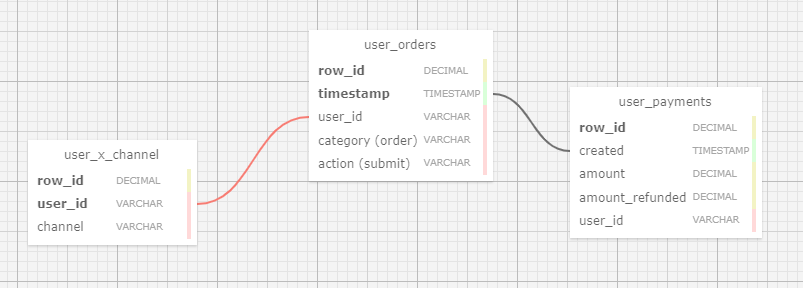

In [ ]:
!pip install psycopg2

import psycopg2
import pandas as pd

DB_HOST = 'de-edu-db.chronosavant.ru'
DB_USER = 'da11'
DB_USER_PASSWORD = 'gandalfthegrey'
DB_NAME = 'edu'

conn = psycopg2.connect(host=DB_HOST, user=DB_USER, password=DB_USER_PASSWORD, dbname=DB_NAME)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
Kazakov = pd.read_sql_query("""
SELECT 
      row_number() over (order by CONCAT(timestamp, '_' , user_orders.user_id)) as row_id,
      CONCAT(timestamp, '_' , user_orders.user_id) as order_id,
      channel AS acquisition_name,
      timestamp, 
      user_orders.user_id,
      /*CASE 
          WHEN amount is null THEN 'заказ_не_оплачен'
          ELSE CAST (amount as varchar)
          END AS amount, */
      amount,
      amount_refunded,
      coalesce(amount - amount_refunded,0) AS amount_after_refund, 
      (coalesce(amount - amount_refunded,0) / (SELECT 
                                                    sum(amount - amount_refunded)
                                              FROM 
                                                    da.user_payments) * 100) as percent_of_all_amount_withref      
                                                    ---% от общей суммы заказов после возвратов                                                               
FROM 
      da.user_orders
LEFT JOIN
      da.user_x_channel
USING(user_id)
LEFT JOIN
      da.user_payments
ON
    user_orders.timestamp = user_payments.created

""", conn)

In [ ]:
Kazakov

,row_id,order_id,acquisition_name,timestamp,user_id,amount,amount_refunded,amount_after_refund,percent_of_all_amount_withref
0,1,2022-04-01 09:12:43_6246ba8adcd39f5d07e3bc69,yandex direct,2022-04-01 09:12:43,6246ba8adcd39f5d07e3bc69,NaN,NaN,0.0,0.000000
1,2,2022-04-01 12:15:23_6246e798c4d5b139d2328729,Organic desktop,2022-04-01 12:15:23,6246e798c4d5b139d2328729,NaN,NaN,0.0,0.000000
2,3,2022-04-02 08:35:43_6247a85b5814321ec2638915,Organic mobile,2022-04-02 08:35:43,6247a85b5814321ec2638915,1500.0,0.0,1500.0,0.036907
3,4,2022-04-03 14:15:44_624980635814321ec2138409,Organic desktop,2022-04-03 14:15:44,624980635814321ec2138409,1499.0,0.0,1499.0,0.036882
4,5,2022-04-04 18:24:52_624b36eb5814321ec2710ad8,Organic mobile,2022-04-04 18:24:52,624b36eb5814321ec2710ad8,1500.0,0.0,1500.0,0.036907
...,...,...,...,...,...,...,...,...,...
2459,2460,2022-09-30 14:55:34_627c6e8b5593fc34cf46d6e6,vk.com,2022-09-30 14:55:34,627c6e8b5593fc34cf46d6e6,1500.0,0.0,1500.0,0.036907
2460,2461,2022-09-30 16:41:59_628bcf50fc37716474a3e00e,vk.com,2022-09-30 16:41:59,628bcf50fc37716474a3e00e,1463.0,0.0,1463.0,0.035997
2461,2462,2022-09-30 17:11:59_62dd7c2c399d11063c1bef42,vk.com,2022-09-30 17:11:59,62dd7c2c399d11063c1bef42,1463.0,0.0,1463.0,0.035997
2462,2463,2022-09-30 18:31:57_62dd7c2c399d11063c1bef42,vk.com,2022-09-30 18:31:57,62dd7c2c399d11063c1bef42,1463.0,0.0,1463.0,0.035997


In [ ]:
Kazakov.to_csv('order_acquisition.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Kazakov.to_csv('order_acquisition.csv')
!cp order_acquisition.csv "drive/My Drive/"